In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from copy import deepcopy



In [2]:
def encoded_pixels_to_masks(fname: str, df: pd.DataFrame):
    fname_df = df[df['ImageId'] == fname]
    masks = np.zeros((256 * 1600, 4), dtype=int) # float32 is V.Imp

    for i_row, row in fname_df.iterrows():
        cls_id = row['ClassId']
        encoded_pixels = row['EncodedPixels']
        if encoded_pixels is not np.nan:
            pixel_list = list(map(int, encoded_pixels.split(' ')))
            for i in range(0, len(pixel_list), 2):
                start_pixel = pixel_list[i] - 1
                num_pixel = pixel_list[i+1]
                masks[start_pixel:(start_pixel+num_pixel), cls_id-1] = 1
                
    masks = masks.reshape(256, 1600, 4, order='F')

    return masks

def masks_to_encoded_pixels(masks: np.ndarray):
    masks = masks.reshape(256*1600, 4, order='F')
    encoded_pixels_list = []
    for cls_id in range(4):
        cls_mask = masks[:, cls_id]
        cls_mask = cls_mask.reshape(256, 1600, order='F')
        cls_mask = cls_mask.T.flatten()
        prev_pixel = 0
        prev_pixel_val = 0
        encoded_pixels = []
        for i, pixel_val in enumerate(cls_mask):
            if pixel_val != prev_pixel_val:
                if pixel_val == 1:
                    start_pixel = i + 1
                    encoded_pixels.append(start_pixel - prev_pixel)
                else:
                    num_pixel = i - prev_pixel
                    encoded_pixels.append(num_pixel)
                prev_pixel = i
                prev_pixel_val = pixel_val
        encoded_pixels_list.append(encoded_pixels)
    return encoded_pixels_list # shape: 4x[]

### Sample example

In [3]:
train_val_csv = 'data/train.csv'
test_csv = 'data/test.csv'

df = pd.read_csv(train_val_csv)

df.ImageId

0       0002cc93b.jpg
1       0007a71bf.jpg
2       000a4bcdd.jpg
3       000f6bf48.jpg
4       0014fce06.jpg
            ...      
7090    ffcf72ecf.jpg
7091    fff02e9c5.jpg
7092    fffe98443.jpg
7093    ffff4eaa8.jpg
7094    ffffd67df.jpg
Name: ImageId, Length: 7095, dtype: object

In [4]:
# let's look at encoded pixels for the first image
img_id = '0002cc93b.jpg'
df[df.ImageId==img_id]

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...


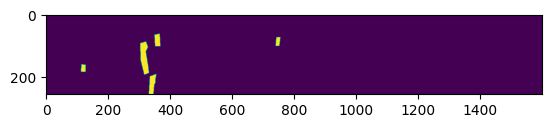

In [5]:
masks = encoded_pixels_to_masks(img_id, df, )
plt.imshow(masks[:,:,0]*255)

In [6]:
img = Image.open(os.path.join('data/train_images',img_id))

In [7]:
np.array(img).shape

(256, 1600, 3)

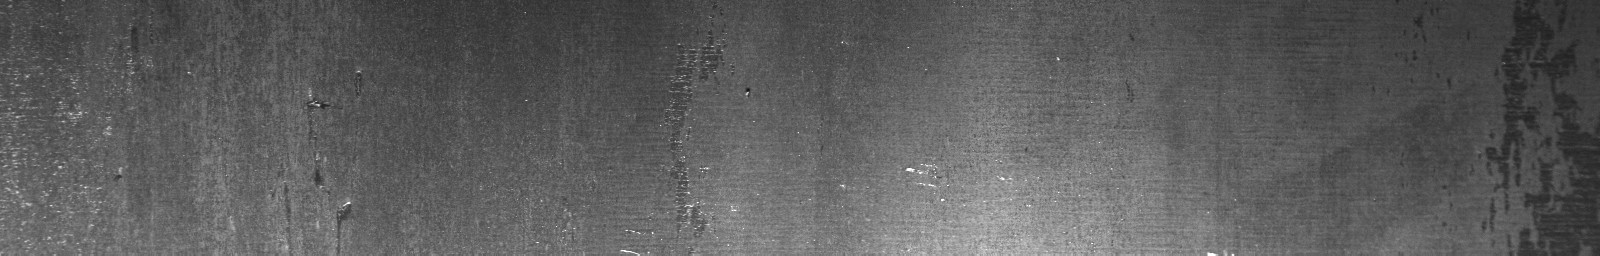

In [8]:
img

In [9]:
# let's encode masks back to encoded pixels
np.array(masks_to_encoded_pixels(masks)[0])

array([29102,    12,   233,    24,   233,    24,   233,    24,   233,
          24,   233,    24,   233,    24,   233,    24,   234,    23,
         234,    23,   234,    23,   234,    23,   234,    23,   234,
          23,   234,    23, 45221,    27,   230,    55,   201,    60,
         197,    64,   193,    68,   189,    72,   184,    77,   180,
          81,   176,    85,   172,    89,   167,    94,   163,    98,
         159,   102,   154,   105,   152,   105,   152,   104,   153,
         104,   152,   105,   152,    31,     5,    69,   155,    27,
          13,    63,   158,    22,    21,    57,   161,    17,    29,
          50,   164,    13,    37,    44,   167,     8,    45,    37,
         171,     3,    53,    31,   232,    25,   238,    18,   249,
           8,   314,    10,   228,    29,   210,    47,   200,    57,
         200,    57,   199,    58,   199,    58,   199,    58,   198,
          59,   198,    59,   198,    59,   197,    60,   197,    60,
         197,    60,

### Your code starts from here

In [10]:
class SeverstalSteelDataset(Dataset):
    def __init__(self, fnames, df, img_dir, transform=None):
        self.df = df.copy()
        self.img_dir = img_dir
        self.fnames = deepcopy(fnames)

    def __len__(self):
        return len(self.fnames)

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_id = self.fnames[idx]
        
        fname = os.path.join(self.img_dir, img_id)
        img = Image.open(fname)
        
        img = np.array(img, dtype=float)
        img = np.transpose(img, (2, 0, 1)) / 255
        
        masks = encoded_pixels_to_masks(img_id, df, )
        masks = np.transpose(masks, (2, 0, 1))
        
        return fname, torch.tensor(img), torch.tensor(masks)


def collate_fn(batch_items):
    fnames = [x[0] for x in batch_items]
    images = [x[1] for x in batch_items]
    masks = [x[2] for x in batch_items]
    
    images = torch.stack(images, dim=0).type(torch.float)
    masks = torch.stack(masks, dim=0).type(torch.float)
    return fnames, images, masks
    

In [11]:
from torchvision.models.segmentation import fcn_resnet50

class SegModel(torch.nn.Module):
    def __init__(self):
        super(SegModel, self).__init__()
        self.model = fcn_resnet50(num_classes=4)

    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
def load_data(train_val_csv, test_csv, train_val_img_dir, test_img_dir):
    train_val_df = pd.read_csv(train_val_csv)
    train_val_fnames = pd.unique(df.ImageId)
    
    train_fnames, val_fnames = train_test_split(train_val_fnames)
    
    train_dataset = SeverstalSteelDataset(train_fnames[:2],train_val_df,train_val_img_dir) 
    val_dataset = SeverstalSteelDataset(val_fnames[:2],train_val_df,train_val_img_dir)

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn, num_workers=0)
    
    return train_loader, val_loader

In [13]:
train_val_csv = 'data/train.csv'
test_csv = 'data/test.csv'
train_val_img_dir = 'data/train_images'
test_img_dir = ''

train_loader, val_loader = load_data(train_val_csv, test_csv, train_val_img_dir,test_img_dir)

In [14]:
# fnames, images, masks = next(iter(train_loader))
# fnames

In [15]:
# images.shape, masks.shape
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SegModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.BCEWithLogitsLoss()

In [48]:
lr = 0.001
epochs = 100

# train
for epoch in range(epochs):
    model.train()
    acc_loss = 0
    for fnames, images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)["out"]
        # print(outputs.shape, masks.shape)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        acc_loss += loss.item()
    acc_loss /= len(train_loader)
    print(f'Epoch: {epoch}, Loss: {acc_loss}')

Epoch: 0, Loss: 0.0028441292233765125
Epoch: 1, Loss: 0.0028229544404894114
Epoch: 2, Loss: 0.0027922671288251877
Epoch: 3, Loss: 0.002773200161755085
Epoch: 4, Loss: 0.0027422525454312563
Epoch: 5, Loss: 0.0027154339477419853
Epoch: 6, Loss: 0.002688990207388997
Epoch: 7, Loss: 0.002666326705366373
Epoch: 8, Loss: 0.0026525056455284357
Epoch: 9, Loss: 0.002626449801027775
Epoch: 10, Loss: 0.0026078519877046347
Epoch: 11, Loss: 0.002581004286184907
Epoch: 12, Loss: 0.0025608735159039497
Epoch: 13, Loss: 0.0025408854708075523
Epoch: 14, Loss: 0.002516302512958646
Epoch: 15, Loss: 0.0025058919563889503
Epoch: 16, Loss: 0.0024754079058766365
Epoch: 17, Loss: 0.0024585267528891563
Epoch: 18, Loss: 0.002437954070046544
Epoch: 19, Loss: 0.002422572113573551
Epoch: 20, Loss: 0.0024001426063477993
Epoch: 21, Loss: 0.0023848311975598335
Epoch: 22, Loss: 0.0023601397406309843
Epoch: 23, Loss: 0.0023373058065772057
Epoch: 24, Loss: 0.0023272517137229443
Epoch: 25, Loss: 0.0023063221015036106
Epoc

In [18]:
fnames, images, masks = next(iter(train_loader))
fnames, images.shape, masks.shape

(['data/train_images/e95faa0b1.jpg', 'data/train_images/b147f0f0f.jpg'],
 torch.Size([2, 3, 256, 1600]),
 torch.Size([2, 4, 256, 1600]))

In [19]:
outputs = model(images)["out"]
outputs = outputs.softmax(dim=1)

In [20]:
outputs.shape

torch.Size([2, 4, 256, 1600])

In [38]:
gt_mask1 = np.transpose(masks.detach().numpy(), (0, 2, 3, 1))[1]
outputs1 = np.transpose(outputs.detach().numpy(), (0, 2, 3, 1))[1]
gt_mask1.shape, outputs1.shape

((256, 1600, 4), (256, 1600, 4))

In [39]:
outputs1[outputs1>0.5] = 1
outputs1[outputs1<0.5] = 0

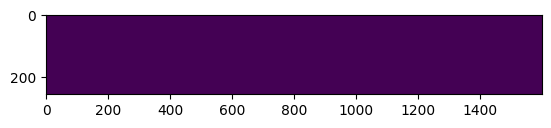

In [47]:
plt.imshow(gt_mask1[:,:,0]*255)

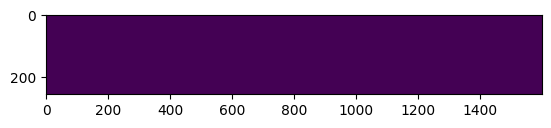

In [46]:
plt.imshow(outputs1[:,:,0]*255)